# 1 - Querying top miner UID

In [ ]:
import bittensor as bt

USE_TESTNET = False

if USE_TESTNET:
    metagraph = bt.metagraph(netuid=118, network="test")
else:
    metagraph = bt.metagraph(netuid=2, network="finney")

top_miner_uid = int(metagraph.incentive.argmax())
print(top_miner_uid)

# 2 - Demonstration of Rewards

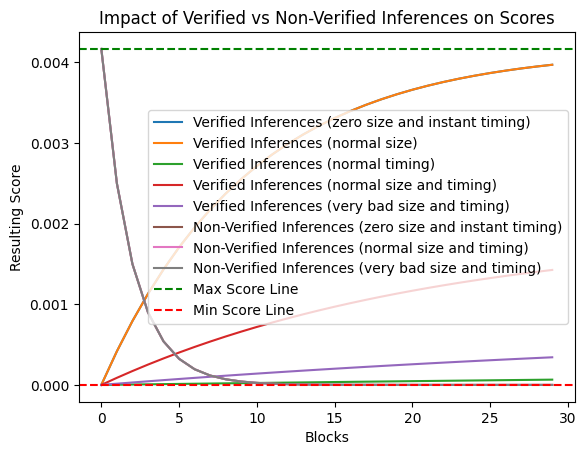

<Figure size 3000x1800 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
from _validator.reward import Reward
import torch

try:
    import matplotlib
except ImportError:
    %pip install matplotlib

PLOT_INTERVALS = 30
MAX_SCORE = 1 / 240
MAX_RESPONSE_TIME = 30
DUMMY_BLOCK_NUMBER = 2000000
DUMMY_HOTKEY = [
            57.0,
            54.0,
            100.0,
            54.0,
            101.0,
            55.0,
            57.0,
            97.0,
            56.0,
            98.0,
            50.0,
            48.0,
            49.0,
            57.0,
            48.0,
            99.0,
            52.0,
            54.0,
            50.0,
            98.0,
            100.0,
            99.0,
            53.0,
            97.0,
            49.0,
            97.0,
            53.0,
            102.0,
            101.0,
            51.0,
            57.0,
            99.0,
            99.0,
            51.0,
            55.0,
            53.0,
            52.0,
            55.0,
            52.0,
            55.0,
            52.0,
            50.0,
            53.0,
            50.0,
            56.0,
            100.0,
            53.0,
            101.0,
            54.0,
            54.0,
            50.0,
            57.0,
            51.0,
            55.0,
            57.0,
            50.0,
            99.0,
            100.0,
            100.0,
            97.0,
            101.0,
            100.0,
            50.0,
            99.0,
        ]

reward_module = Reward()


# Define plotter
def plot_values(values, label, linestyle="-"):
    plt.plot(
        [i for i in range(PLOT_INTERVALS)], values, label=label, linestyle=linestyle
    )


# Generate mock reward values
def generate_proven_values(initial_score, verified, size=0, timing=0):
    values = [initial_score]
    for _ in range(PLOT_INTERVALS - 1):
        tensor_score, _, _ = reward_module.forward(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME), torch.tensor(size), torch.tensor(DUMMY_HOTKEY), torch.tensor(DUMMY_BLOCK_NUMBER))
        values.append(tensor_score.item())
        initial_score = tensor_score.item()

plot_values(
    generate_proven_values(0, True),
    "Verified Inferences (zero size and instant timing)",
)
plot_values(generate_proven_values(0, True, 3648), "Verified Inferences (normal size)")
plot_values(
    generate_proven_values(0, True, 0, 30), "Verified Inferences (normal timing)"
)
plot_values(
    generate_proven_values(0, True, 3648, 20),
    "Verified Inferences (normal size and timing)",
)
plot_values(
    generate_proven_values(0, True, 100000, 290),
    "Verified Inferences (very bad size and timing)",
)
plot_values(
    generate_proven_values(MAX_SCORE, False),
    "Non-Verified Inferences (zero size and instant timing)",
)
plot_values(
    generate_proven_values(MAX_SCORE, False, 21353, 20),
    "Non-Verified Inferences (normal size and timing)",
)
plot_values(
    generate_proven_values(MAX_SCORE, False, 1000000, 300),
    "Non-Verified Inferences (very bad size and timing)",
)

# Plotting configurations
plt.axhline(y=MAX_SCORE, color="g", linestyle="--", label="Max Score Line")
plt.axhline(y=0, color="r", linestyle="--", label="Min Score Line")
plt.xlabel("Blocks")
plt.ylabel("Resulting Score")
plt.title("Impact of Verified vs Non-Verified Inferences on Scores")
plt.legend()
plt.figure(figsize=(10, 6), dpi=300)
plt.show()

/var/folders/by/whcxqk1j1dq0qrcy975ljpsw0000gn/T/ipykernel_37209/1060949814.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_score, _, _, _ = reward.forward(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(size), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME), torch.tensor(MIN_RESPONSE_TIME - 0.5), torch.tensor(DUMMY_HOTKEY), torch.tensor(DUMMY_BLOCK_NUMBER), torch.tensor(DUMMY_MINER_UID))


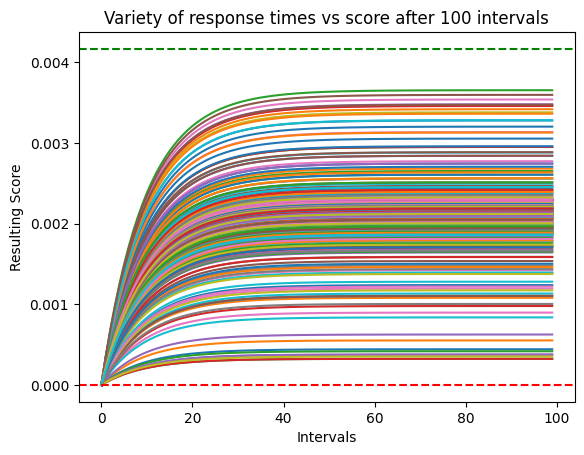

<Figure size 3000x1800 with 0 Axes>

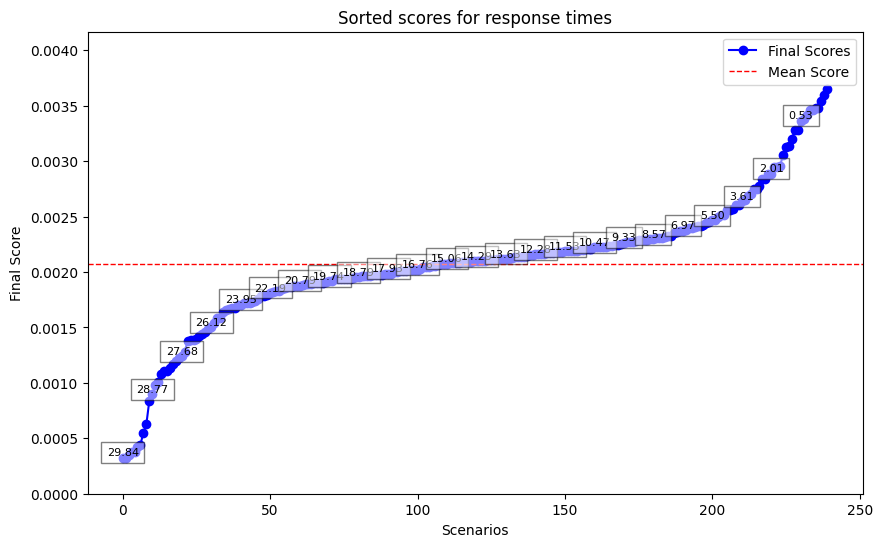

In [15]:
import random
import numpy as np
import torch
import os
current_dir = os.getcwd()
from _validator.reward import Reward
target_dir = os.path.join(current_dir, 'deployment_layer', f'model_{1}')

if current_dir.endswith("neurons"):
    os.chdir(target_dir)

import matplotlib.pyplot as plt
import onnxruntime as ort

# Constants
USE_ONNX = False
MAX_RESPONSE_TIME = 30
MIN_RESPONSE_TIME = 0
NUM_KEYS_TO_SIMULATE = 240

PLOT_INTERVALS = 100
MAX_SCORE = 1 / NUM_KEYS_TO_SIMULATE
MAX_RESPONSE_TIME = 30
DUMMY_BLOCK_NUMBER = 2000000
DUMMY_HOTKEY = [
            57.0,
            54.0,
            100.0,
            54.0,
            101.0,
            55.0,
            57.0,
            97.0,
            56.0,
            98.0,
            50.0,
            48.0,
            49.0,
            57.0,
            48.0,
            99.0,
            52.0,
            54.0,
            50.0,
            98.0,
            100.0,
            99.0,
            53.0,
            97.0,
            49.0,
            97.0,
            53.0,
            102.0,
            101.0,
            51.0,
            57.0,
            99.0,
            99.0,
            51.0,
            55.0,
            53.0,
            52.0,
            55.0,
            52.0,
            55.0,
            52.0,
            50.0,
            53.0,
            50.0,
            56.0,
            100.0,
            53.0,
            101.0,
            54.0,
            54.0,
            50.0,
            57.0,
            51.0,
            55.0,
            57.0,
            50.0,
            99.0,
            100.0,
            100.0,
            97.0,
            101.0,
            100.0,
            50.0,
            99.0,
        ]
DUMMY_MINER_UID = 110
DUMMY_PROOF_SIZE = 3648

reward = Reward()
ort_session = ort.InferenceSession("network.onnx")

# Define plotter
def plot_values(values, label, linestyle="-"):
    plt.plot([i for i in range(PLOT_INTERVALS)], values, label=label, linestyle=linestyle)

# Generate mock reward values
def generate_proven_values(initial_score, verified, size=0, timing=0):
    values = [initial_score]
    for _ in range(PLOT_INTERVALS - 1):

        if USE_ONNX:
            tensor_score = ort_session.run(["output"], {ort_session.get_inputs()[0].name: np.array([MAX_SCORE], dtype=np.float32), ort_session.get_inputs()[1].name: np.array([initial_score], dtype=np.float32), ort_session.get_inputs()[2].name: np.array([verified], dtype=np.bool_), ort_session.get_inputs()[3].name: np.array([timing], dtype=np.float32), ort_session.get_inputs()[4].name: np.array([MAX_RESPONSE_TIME], dtype=np.float32), ort_session.get_inputs()[5].name: np.array(DUMMY_HOTKEY, dtype=np.int32), ort_session.get_inputs()[6].name: np.array([DUMMY_BLOCK_NUMBER], dtype=np.int32), ort_session.get_inputs()[7].name: np.array([DUMMY_MINER_UID], dtype=np.int32)})
            values.append(tensor_score[0][0])
            initial_score = tensor_score[0][0]
        else:
            tensor_score, _, _, _ = reward.forward(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(size), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME), torch.tensor(MIN_RESPONSE_TIME - 0.5), torch.tensor(DUMMY_HOTKEY), torch.tensor(DUMMY_BLOCK_NUMBER), torch.tensor(DUMMY_MINER_UID))
            values.append(tensor_score)
            initial_score = tensor_score


    return values


random_response_times = [
    random.uniform(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME)
    for _ in range(NUM_KEYS_TO_SIMULATE)
]

for i, response_time in enumerate(random_response_times):
    plot_values(generate_proven_values(0, True, 0, response_time), f"Miner {i+1}")

# Plotting configurations for the new chart
plt.axhline(
    y=1 / NUM_KEYS_TO_SIMULATE, color="g", linestyle="--", label="Max Score Line"
)
plt.axhline(y=0, color="r", linestyle="--", label="Min Score Line")
plt.xlabel("Intervals")
plt.ylabel("Resulting Score")
plt.title(f"Variety of response times vs score after {PLOT_INTERVALS} intervals")
plt.figure(figsize=(10, 6), dpi=300)
plt.show()

final_scores_random = [
    generate_proven_values(0, True, 3648, rt)[-1] for rt in random_response_times
]

# Sort both the times and the scores by the score
sorted_indices = np.argsort(final_scores_random)
sorted_final_scores_random = np.array(final_scores_random)[sorted_indices]
sorted_response_times = np.array(random_response_times)[sorted_indices]

# Plot scores and timings
plt.figure(figsize=(10, 6))
plt.plot(
    sorted_final_scores_random,
    color="blue",
    marker="o",
    linestyle="-",
    label="Final Scores",
)

# Show annotations above 1/10 of the points with the response time
for i, (score, response_time) in enumerate(
    zip(sorted_final_scores_random, sorted_response_times)
):
    if i % 10 == 0:
        plt.text(
            i,
            score,
            f"{response_time:.2f}",
            fontsize=8,
            ha="center",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.5),
        )

plt.axhline(
    np.mean(sorted_final_scores_random),
    color="r",
    linestyle="dashed",
    linewidth=1,
    label="Mean Score",
)
plt.xlabel("Scenarios")
plt.ylim(0, MAX_SCORE)
plt.ylabel("Final Score")
plt.title("Sorted scores for response times")
plt.legend()
plt.show()

## Proof of Weights

/var/folders/by/whcxqk1j1dq0qrcy975ljpsw0000gn/T/ipykernel_37209/2323431336.py:147: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_score = run_inference_via_proof_system(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME))
/var/folders/by/whcxqk1j1dq0qrcy975ljpsw0000gn/T/ipykernel_37209/2323431336.py:150: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_score_torch = reward.forward(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME), torch.tensor(size), torch.tensor(MIN_RESPONSE_TIME - 0.5), torch.tensor(DUMMY_HOTKEY), torch.t

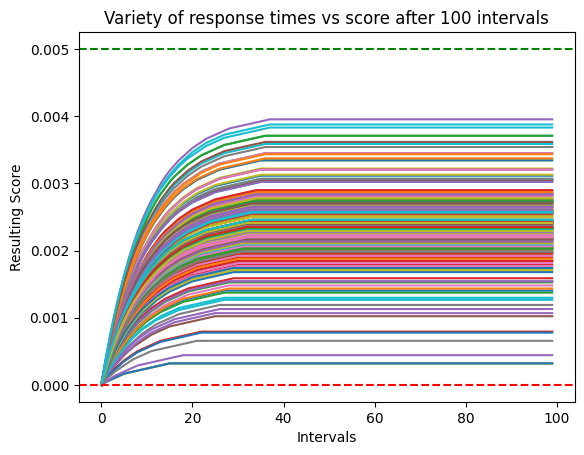

<Figure size 3000x1800 with 0 Axes>

[tensor(3.8828e-05, dtype=torch.float64), tensor(0.0002, dtype=torch.float64), tensor(0.0004, dtype=torch.float64), tensor(0.0006, dtype=torch.float64), tensor(0.0008, dtype=torch.float64), tensor(0.0009, dtype=torch.float64), tensor(0.0010, dtype=torch.float64), tensor(0.0011, dtype=torch.float64), tensor(0.0012, dtype=torch.float64), tensor(0.0013, dtype=torch.float64), tensor(0.0014, dtype=torch.float64), tensor(0.0015, dtype=torch.float64), tensor(0.0015, dtype=torch.float64), tensor(0.0016, dtype=torch.float64), tensor(0.0016, dtype=torch.float64), tensor(0.0017, dtype=torch.float64), tensor(0.0017, dtype=torch.float64), tensor(0.0018, dtype=torch.float64), tensor(0.0018, dtype=torch.float64), tensor(0.0018, dtype=torch.float64), tensor(0.0019, dtype=torch.float64), tensor(0.0019, dtype=torch.float64), tensor(0.0019, dtype=torch.float64), tensor(0.0019, dtype=torch.float64), tensor(0.0019, dtype=torch.float64), tensor(0.0020, dtype=torch.float64), tensor(0.0020, dtype=torch.float6

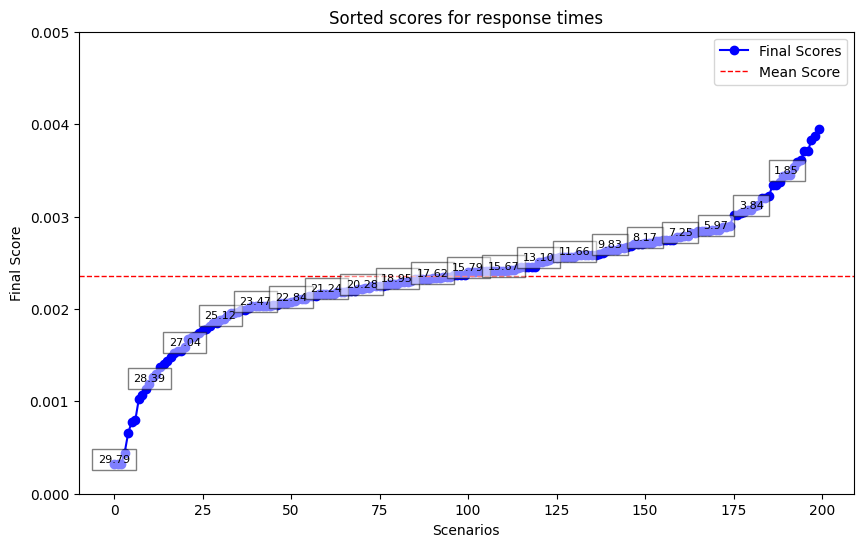

In [16]:
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import ezkl
import json
import os
import torch
from decimal import Decimal
from _validator.reward import Reward

MAX_RESPONSE_TIME = 30
MIN_RESPONSE_TIME = 0
NUM_KEYS_TO_SIMULATE = 200

PLOT_INTERVALS = 100
MAX_SCORE = 1 / NUM_KEYS_TO_SIMULATE
MAX_RESPONSE_TIME = 30
DUMMY_BLOCK_NUMBER = 2000000
DUMMY_HOTKEY = [
            57.0,
            54.0,
            100.0,
            54.0,
            101.0,
            55.0,
            57.0,
            97.0,
            56.0,
            98.0,
            50.0,
            48.0,
            49.0,
            57.0,
            48.0,
            99.0,
            52.0,
            54.0,
            50.0,
            98.0,
            100.0,
            99.0,
            53.0,
            97.0,
            49.0,
            97.0,
            53.0,
            102.0,
            101.0,
            51.0,
            57.0,
            99.0,
            99.0,
            51.0,
            55.0,
            53.0,
            52.0,
            55.0,
            52.0,
            55.0,
            52.0,
            50.0,
            53.0,
            50.0,
            56.0,
            100.0,
            53.0,
            101.0,
            54.0,
            54.0,
            50.0,
            57.0,
            51.0,
            55.0,
            57.0,
            50.0,
            99.0,
            100.0,
            100.0,
            97.0,
            101.0,
            100.0,
            50.0,
            99.0,
        ]
DUMMY_MINER_UID = 110
DUMMY_PROOF_SIZE = 3648

import os
reward = Reward()
current_dir = os.getcwd()
PROOF_OF_WEIGHTS_MODEL_ID = "0a92bc32ea02abe54159da70aeb541d52c3cba27c8708669eda634e096a86f8b"
target_dir = os.path.join(current_dir, 'deployment_layer', f'model_{PROOF_OF_WEIGHTS_MODEL_ID}')

torch_scores = []
witness_scores = []

if current_dir.endswith("neurons"):
    os.chdir(target_dir)


def convert_to_hex(value: str):
    """
    Reverse endianness and prepend 0x
    """
    if isinstance(value, list):
        return "" + value[0][::-1]
    return "" + value[::-1]

def run_inference_via_proof_system(max_score, initial_score, verified, response_time, max_response_time):
    with open("input.json", "w", encoding="utf-8") as f:
        json_obj = {
            "input_data": [[max_score.item()],
            [initial_score.item()],
            [int(verified.item())],
            [DUMMY_PROOF_SIZE],
            [response_time.item()],
            [max_response_time.item()],
            [MIN_RESPONSE_TIME - 0.5],
            DUMMY_HOTKEY,
            [DUMMY_BLOCK_NUMBER],
            [DUMMY_MINER_UID]],
        }
        f.write(json.dumps(json_obj))

    ezkl.gen_witness(data="input.json", model="model.compiled", output="witness.json", vk_path="vk.key", srs_path="kzg.srs")
    scaling_factor = 15
    with open("settings.json", "r", encoding="utf-8") as settings_file:
        settings_json = json.load(settings_file)
        scaling_factor = settings_json["model_output_scales"][0]

    with open("witness.json", "r", encoding="utf-8") as witness_file:
        witness_json = json.load(witness_file)
        output_values = witness_json["outputs"]
        return torch.tensor(ezkl.felt_to_float(output_values[0][0], scaling_factor), dtype=torch.float64)


# Define plotter
def plot_values(values, label, linestyle="-"):
    plt.plot([i for i in range(PLOT_INTERVALS)], values, label=label, linestyle=linestyle)


# Generate mock reward values
def generate_proven_values(initial_score, verified, size=0, timing=0):
    values = [initial_score]
    for _ in range(PLOT_INTERVALS - 1):
        new_score = run_inference_via_proof_system(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME))
        witness_scores.append(new_score)
        # Compare score to pytorch run
        new_score_torch = reward.forward(torch.tensor(MAX_SCORE), torch.tensor(initial_score), torch.tensor(verified), torch.tensor(timing), torch.tensor(MAX_RESPONSE_TIME), torch.tensor(size), torch.tensor(MIN_RESPONSE_TIME - 0.5), torch.tensor(DUMMY_HOTKEY), torch.tensor(DUMMY_BLOCK_NUMBER), torch.tensor(DUMMY_MINER_UID))
        torch_scores.append(new_score_torch[0])
        values.append(new_score)
        initial_score = new_score
    return values


random_response_times = [
    random.uniform(MIN_RESPONSE_TIME, MAX_RESPONSE_TIME)
    for _ in range(NUM_KEYS_TO_SIMULATE)
]

for i, response_time in enumerate(random_response_times):
    plot_values(generate_proven_values(torch.tensor(0, dtype=torch.float64), True, 0, response_time), f"Miner {i+1}")

# Plotting configurations for the new chart
plt.axhline(
    y=1 / NUM_KEYS_TO_SIMULATE, color="g", linestyle="--", label="Max Score Line"
)
plt.axhline(y=0, color="r", linestyle="--", label="Min Score Line")
plt.xlabel("Intervals")
plt.ylabel("Resulting Score")
plt.title(f"Variety of response times vs score after {PLOT_INTERVALS} intervals")
plt.figure(figsize=(10, 6), dpi=300)
plt.show()

final_scores_random = [
    generate_proven_values(0, True, 3648, rt)[-1] for rt in random_response_times
]

# Sort both the times and the scores by the score
sorted_indices = np.argsort(final_scores_random)
sorted_final_scores_random = np.array(final_scores_random)[sorted_indices]
sorted_response_times = np.array(random_response_times)[sorted_indices]

# Plot scores and timings
plt.figure(figsize=(10, 6))
plt.plot(
    sorted_final_scores_random,
    color="blue",
    marker="o",
    linestyle="-",
    label="Final Scores",
)

# Show annotations above 1/10 of the points with the response time
for i, (score, response_time) in enumerate(
    zip(sorted_final_scores_random, sorted_response_times)
):
    if i % 10 == 0:
        plt.text(
            i,
            score,
            f"{response_time:.2f}",
            fontsize=8,
            ha="center",
            va="bottom",
            bbox=dict(facecolor="white", alpha=0.5),
        )

plt.axhline(
    np.mean(sorted_final_scores_random),
    color="r",
    linestyle="dashed",
    linewidth=1,
    label="Mean Score",
)

print(f"{torch_scores}, {type(torch_scores)}, {witness_scores}, {type(witness_scores)}")

plt.xlabel("Scenarios")
plt.ylim(0, MAX_SCORE)
plt.ylabel("Final Score")
plt.title("Sorted scores for response times")
plt.legend()
plt.show()

# 3 - N/A